In [1]:
import os

def count_files_in_directory(directory):
    file_count = 0
    for root, dirs, files in os.walk(directory):
        file_count += len(files)
    return file_count

directory_path = "../data/chipped_224/"

In [2]:
count_files_in_directory(directory_path)
count_files_in_directory("../data/output_multi/MS/")

18629

In [4]:
import os
import collections
def count_files_by_prefix(directory):
    """
    Counts the number of files in a directory, grouping by:
    - First prefix before the first "_"
    - Second prefix before the second "_"
    
    Example:
    - "image1_0_0.tif" → ('image1', '0')
    - "image1_0_224.tif" → ('image1', '0')
    - "image2_1_0.tif" → ('image2', '1')
    
    Output:
    {
        'image1': {'0': 100, '1': 50},
        'image2': {'0': 80, '1': 60},
        ...
    }
    """
    file_counts = collections.defaultdict(lambda: collections.defaultdict(int))

    for filename in os.listdir(directory):
        if filename.endswith(".tif") or filename.endswith(".TIF"):
            parts = filename.split("_")

            if len(parts) >= 2:  # Ensure there are at least two prefixes
                first_prefix = parts[0]
                second_prefix = parts[3]

                file_counts[first_prefix][second_prefix] += 1

    return file_counts


In [5]:
output_dir = "../data/output_multi/MS/"  # Update this path
file_counts = count_files_by_prefix(output_dir)

# Print results, sorting alphabetically by both first and second prefix
for first_prefix in sorted(file_counts.keys()):
    print(f"{first_prefix}:")
    for second_prefix, count in sorted(file_counts[first_prefix].items(), key=lambda x: x[0]):  # Sorted as string
        print(f"  {second_prefix}: {count} files")

ALTUM:
  beechforest: 325 files
  macroalgae: 600 files
REDEDGE:
  blueberry: 343 files
  botrytis: 6532 files
  contamination: 1924 files
  forestfuel: 4439 files
  potato: 347 files
  rivers: 95 files
SEQUOIA:
  cherry: 16 files
  diurnal: 61 files
  localization: 448 files
  nature: 2009 files
  subtropical: 1490 files


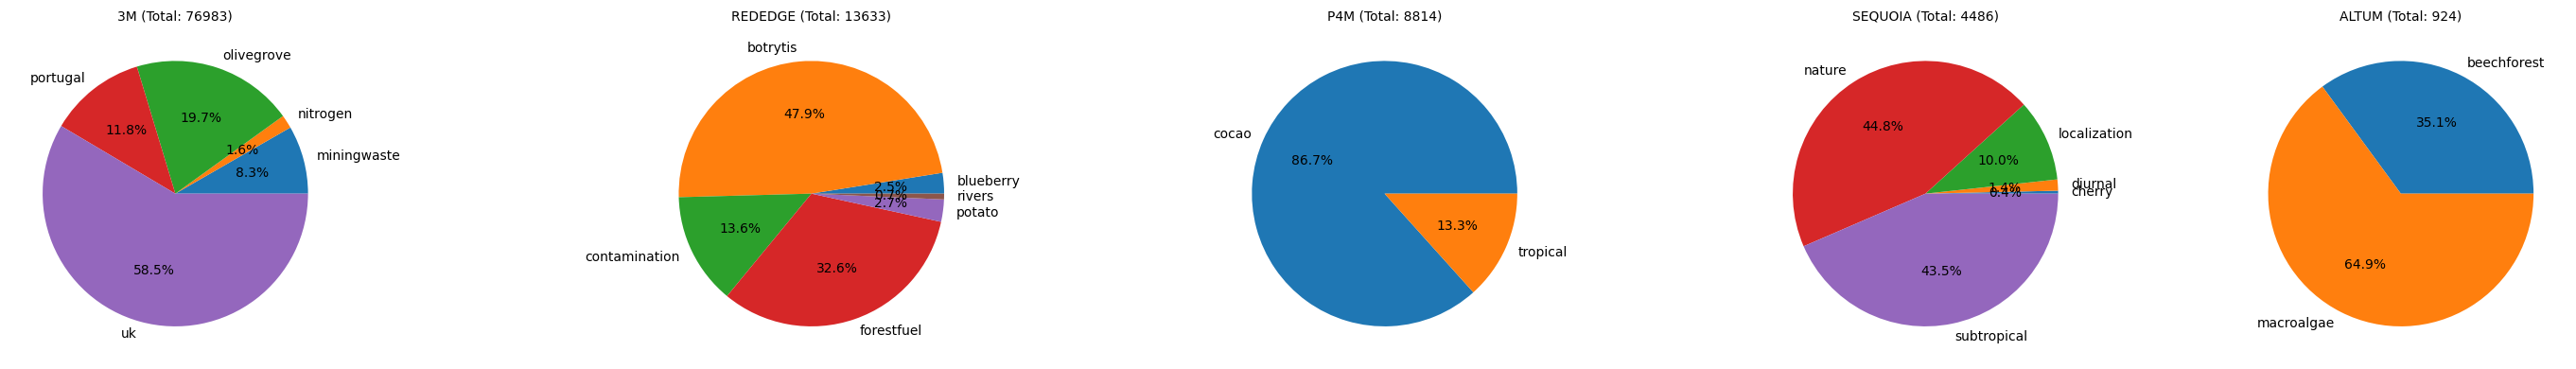

In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math

#------------------------------------------------------
# 1. Compute (prefix, total_count) pairs and sort by total_count
# ---------------------------------------------------------------------
prefix_sums = []
for prefix in file_counts:
    total = sum(file_counts[prefix].values())
    prefix_sums.append((prefix, total))

# Sort by total ascending (smallest on left → largest on right)
# If you want largest on left instead, use `reverse=True`.
prefix_sums.sort(key=lambda x: x[1], reverse=True)

# Extract the sorted prefixes and their totals in parallel lists
prefixes = [x[0] for x in prefix_sums]
prefix_totals = [x[1] for x in prefix_sums]

# ---------------------------------------------------------------------
# 2. Log-scale the totals to avoid huge chart widths
# ---------------------------------------------------------------------
# Use log10(t + 1) to compress large values.
log_totals = [math.log10(t + 1) for t in prefix_totals]

# If some totals are extremely large, you can clamp the log values:
# log_totals = [min(6, max(1, val)) for val in log_totals]

# ---------------------------------------------------------------------
# 3. Configure the overall figure size and gridspec
# ---------------------------------------------------------------------
sum_of_logs = sum(log_totals)

base_height = 4            # Height (inches) of the figure
base_unit_width = 1.5      # Controls how wide each log-unit is
figure_width = base_unit_width * sum_of_logs

fig = plt.figure(figsize=(figure_width, base_height))

# We have one row, with as many subplots as there are prefixes
gs = gridspec.GridSpec(1, len(prefixes), width_ratios=log_totals)

# ---------------------------------------------------------------------
# 4. Plot each prefix’s pie chart in its proportional subplot
# ---------------------------------------------------------------------
for i, prefix in enumerate(prefixes):
    ax = fig.add_subplot(gs[i])
    
    # Sort subprefixes alphabetically (or by count if you prefer)
    sub_dict = file_counts[prefix]
    second_prefixes = sorted(sub_dict.keys())
    counts = [sub_dict[sp] for sp in second_prefixes]
    
    # Create the pie chart in this subplot
    ax.pie(counts, labels=second_prefixes, autopct='%1.1f%%')
    
    # Title showing prefix and total
    total_count = prefix_totals[i]
    ax.set_title(f"{prefix} (Total: {total_count})", fontsize=10)

plt.tight_layout()
plt.savefig("pie.png", dpi=300)
plt.show()



In [6]:
import os
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from pathlib import Path

import tifffile as tiff
import numpy as np
from skimage.transform import resize
import cv2

def load_tif_image(filepath):
    """
    Load a 4-band TIFF image and return as a NumPy array (uint16).
    If the image is very large (height or width > 10k), it will be
    downsampled by a factor of 10.
    """
    # Read the image (H, W, 4)
    img = tiff.imread(filepath)
    print(f"Original shape: {img.shape}, dtype: {img.dtype}")

    # If any dimension is >10,000, downsample by factor of 10
    if img.shape[0] > 3000 or img.shape[1] > 3000:
        print("Downscaling with OpenCV to 10% size...")
        new_height = int(img.shape[0] * 0.1)
        new_width = int(img.shape[1] * 0.1)
        # Note: OpenCV expects (width, height)
        resized = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
        img = resized.astype(np.uint16)

    return img
    

def plot_images(image, title_prefix, save_path):
    """Generate and save multiple visualizations for a 4-band image."""
    bands = ['GRE', 'RED', 'REDEDGE', 'NIR']
    
    # Plot individual bands
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    for i in range(4):
        ax = axes[i // 2, i % 2]
        ax.imshow(image[:, :, i], cmap='gray')
        ax.set_title(f"{title_prefix} - {bands[i]}")
        ax.axis("off")
    
    # False Color Composite (NIR, RED, GREEN)
    false_color = np.stack([image[:, :, 3], image[:, :, 1], image[:, :, 0]], axis=-1)  # (H, W, 3)
    print(image.shape)
    false_color = false_color / np.max(false_color)  # Normalize for visualization
    
    ax_false = axes[0, 2]
    ax_false.imshow(false_color)
    ax_false.set_title(f"{title_prefix} - False Color (NIR, RED, GREEN)")
    ax_false.axis("off")
    
    # Zoomed-in False Color (20x)
    zoom_factor = 20
    h, w, _ = image.shape
    center_x, center_y = w // 2, h // 2
    zoom_size_x, zoom_size_y = w // (2 * zoom_factor), h // (2 * zoom_factor)
    
    zoomed = false_color[
        center_y - zoom_size_y:center_y + zoom_size_y,
        center_x - zoom_size_x:center_x + zoom_size_x,
        :
    ]
        
    ax_zoom = axes[1, 2]
    ax_zoom.imshow(zoomed)
    ax_zoom.set_title(f"{title_prefix} - False Color Zoomed (20x)")
    ax_zoom.axis("off")

    # Save the visualization
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

def plot_histogram(image, title_prefix, save_path):
    """Plot histograms for all 4 bands and save as an image."""
    bands = ['GRE', 'RED', 'REDEDGE', 'NIR']
    fig, ax = plt.subplots(figsize=(8, 6))

    for i in range(4):
        ax.hist(image[:, :, i].ravel(), bins=256, alpha=0.6, label=bands[i], histtype='step')

    ax.set_title(f"{title_prefix} - Histogram of Bands")
    ax.set_xlabel("Pixel Intensity")
    ax.set_ylabel("Frequency")
    ax.legend()
    
    plt.savefig(save_path, dpi=300)
    plt.close()


def process_directory(root_dir, output_dir):
    """Process all subdirectories containing TIFF files and save outputs to the given directory."""
    root_path = Path(root_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)  # Ensure output directory exists

    for sub_dir in root_path.iterdir():
        sub_output_dir = Path(output_dir) / sub_dir.name
        
        if os.path.exists(sub_output_dir):
            print("Skipping" + str(sub_output_dir))
            continue
            
        if sub_dir.is_dir():
            process_single_subfolder(root_dir, sub_dir.name, output_dir)

def process_single_subfolder(root_dir, subfolder_name, output_dir):
    """Process a specific subfolder, handling cases with one or multiple images."""
    sub_path = Path(root_dir) / subfolder_name
    if not sub_path.is_dir():
        print(f"Subfolder {subfolder_name} not found in {root_dir}")
        return
    
    tif_files = sorted(sub_path.glob("*.tif"))  # Sort to get first and last
    if len(tif_files) == 0:
        print(f"Skipping {subfolder_name}: No TIFF files found.")
        return
    
    first_tif = tif_files[0]  # Always process the first image
    last_tif = tif_files[-1] if len(tif_files) > 1 else None  # Only set last if there's more than one
    
    print(f"Processing {subfolder_name}: {first_tif.name}" + (f", {last_tif.name}" if last_tif else " (Only 1 image)"))

    # Load the first image
    img_first = load_tif_image(first_tif)

    # Create a subfolder in the output directory
    sub_output_dir = Path(output_dir) / subfolder_name
    sub_output_dir.mkdir(parents=True, exist_ok=True)

    # Define save paths
    save_path_first = sub_output_dir / f"{subfolder_name}_first.png"
    save_path_hist_first = sub_output_dir / f"{subfolder_name}_hist_first.png"

    # Generate and save plots for the first image
    plot_images(img_first, f"{subfolder_name} - First", save_path_first)
    plot_histogram(img_first, f"{subfolder_name} - First", save_path_hist_first)

    print(f"Saved plots for {subfolder_name} in {sub_output_dir}")

    # If there's a second image, process it as well
    if last_tif and last_tif != first_tif:
        img_last = load_tif_image(last_tif)
        save_path_last = sub_output_dir / f"{subfolder_name}_last.png"
        save_path_hist_last = sub_output_dir / f"{subfolder_name}_hist_last.png"
        
        plot_images(img_last, f"{subfolder_name} - Last", save_path_last)
        plot_histogram(img_last, f"{subfolder_name} - Last", save_path_hist_last)

        print(f"Saved additional plots for last image in {sub_output_dir}")


In [8]:

# Set your paths here
directory_path = "../data/output_multi/" # Change to your actual input directory
output_directory = "../data/plots_multi"  # Change to your desired output directory
os.makedirs(output_directory, exist_ok=True)
process_directory(directory_path, output_directory)

Processing MS: ALTUM_CAL_altum_beechforest_Hullerbusch_Orthomosaic-reflectance0-1_AltumMSI_1072_1031.tif, SEQUOIA_SUNCAL_sequoia_subtropical_c_IMG_201022_180442_0293_GRE_224_640.tif
Original shape: (512, 512, 5), dtype: uint8
(512, 512, 5)
Saved plots for MS in ..\data\plots_multi\MS
Original shape: (512, 512, 4), dtype: uint8
(512, 512, 4)
Saved additional plots for last image in ..\data\plots_multi\MS
Skipping RGB: No TIFF files found.


In [4]:
import glob
import cv2
import numpy as np

# Path to folder containing 0-255 scaled TIF images
image_folder = "../data/chipped_336"
tif_paths = glob.glob(f"{image_folder}/*.tif")[::100] # every 100th img for an estimate

all_pixels = []

for tif_path in tif_paths:
    # Read the image in unchanged mode (to preserve exact channel depth)
    img = cv2.imread(tif_path, cv2.IMREAD_UNCHANGED)

    # Ensure we have a 3D array: shape (H, W, C). 
    # If it's single-channel (H, W), we add a new axis to get (H, W, 1).
    if len(img.shape) == 2:  # grayscale TIF
        img = img[:, :, np.newaxis]

    # Reshape to (num_pixels, num_channels), so we can stack across images
    h, w, c = img.shape
    img_reshaped = img.reshape(-1, c)  # e.g., (H*W, C)

    all_pixels.append(img_reshaped)

# Combine all pixels from all images into one big array
all_pixels = np.concatenate(all_pixels, axis=0)  # shape: (total_pixels, C)

# Compute mean and std per channel
mean_vals = all_pixels.mean(axis=0)  # shape: (C,)
std_vals  = all_pixels.std(axis=0)   # shape: (C,)

print("Number of channels:", mean_vals.shape[0])
for i, (m, s) in enumerate(zip(mean_vals, std_vals)):
    print(f"Channel {i}: mean={m:.4f}, std={s:.4f}")

Number of channels: 4
Channel 0: mean=39.7075, std=30.8822
Channel 1: mean=15.8885, std=16.7861
Channel 2: mean=18.5576, std=15.7978
Channel 3: mean=100.3117, std=44.8835


For satellite or aerial TIFs, each band can have its own typical distribution. For instance, if you have (R, G, B, NIR) channels, the NIR channel may be brighter or darker on average than the visible bands, depending on vegetation and scene composition. In such cases:

    There is no single “universal” mean/std pair.
    It’s usually best to compute statistics for your exact dataset or at least a representative subset.
The NIR Band has higher values which looks nice, as for red being much lower.

This are radiance -> minmax scaled -> (DINO) normalized around abovementioned values

In [36]:
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile 
outdir = "examples/MS"
image_folder = "../data/output_multi/MS"
tif_paths = glob.glob(f"{image_folder}/*.tif")[::1000] # every 1000th img for an estimate

for i, tif_path in enumerate(tif_paths):
    
    img =  tifffile.imread(tif_path)
    if img is None:
        print(f"Warning: could not read {tif_path}")
        continue
    
    # Handle both 4-channel and 5-channel images
    if img.ndim != 3:
        print(f"Skipping {tif_path}: expected 3D array, got shape {img.shape}")
        continue
    
    num_channels = img.shape[2]
    
    if num_channels == 4:
        # 4-channel case: GRRENIR (G=0, R=1, RE=2, NIR=3)
        # False color: NIR=3, R=1, G=0
        false_color = img[..., [3, 1, 0]]  # shape: (H, W, 3)
        print(f"Processing 4-channel image: {tif_path}")
        
    elif num_channels == 5:
        # 5-channel case: assuming additional channel, adapt indices as needed
        # You may need to adjust these indices based on your specific channel arrangement
        # Example: if channels are [G, R, RE, NIR, Extra], use NIR=3, R=1, G=0
        false_color = img[..., [4, 2, 1]]  # shape: (H, W, 3)
        print(f"Processing 5-channel image: {tif_path}")
        
    else:
        print(f"Skipping {tif_path}: expected 4 or 5 channels, got {num_channels} channels with shape {img.shape}")
        continue
    
    # Convert to float and scale to [0,1] for display
    false_color_norm = false_color.astype(np.float32) / 255
    
    # Handle potential clipping for better visualization
    false_color_norm = np.clip(false_color_norm, 0, 1)
    
    parts = os.path.basename(tif_path).split("_")
    name = parts[0] + "_" + parts[3] + "_" + str(i)
    
    fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))
    
    ax1.imshow(false_color_norm)
    ax1.axis("off")  # Remove ticks and labels for ax1
    
    # Remove any potential titles
    ax1.set_title("")
    plt.suptitle("")  # Remove figure title if any
    
    # Create output directory if it doesn't exist
    os.makedirs(outdir, exist_ok=True)
    
    out_name = f"color_{name}.png"
    plt.savefig(os.path.join(outdir, out_name), bbox_inches="tight", dpi=150)
    plt.close()
    
    print(f"Saved: {out_name}")

print("Processing complete!")

Processing 5-channel image: ../data/output_multi/MS\ALTUM_CAL_altum_beechforest_Hullerbusch_Orthomosaic-reflectance0-1_AltumMSI_1072_1031.tif
Saved: color_ALTUM_beechforest_0.png
Processing 5-channel image: ../data/output_multi/MS\REDEDGE_CAL_rededge_blueberry_Babe_registrated_corrected_transparent_mosaic_2682_5232.tif
Saved: color_REDEDGE_blueberry_1.png
Processing 5-channel image: ../data/output_multi/MS\REDEDGE_CAL_rededge_forestfuel_jcksn_c9_z504_40_609.tif
Saved: color_REDEDGE_forestfuel_2.png
Processing 5-channel image: ../data/output_multi/MS\REDEDGE_CAL_rededge_forestfuel_ppwd_c1_z12_1188_3254.tif
Saved: color_REDEDGE_forestfuel_3.png
Processing 5-channel image: ../data/output_multi/MS\REDEDGE_CAL_rededge_forestfuel_ppwd_c1_z8_6678_5675.tif
Saved: color_REDEDGE_forestfuel_4.png
Processing 5-channel image: ../data/output_multi/MS\REDEDGE_CAL_rededge_forestfuel_sdlmtn_c6_z2_9269_6694.tif
Saved: color_REDEDGE_forestfuel_5.png
Processing 5-channel image: ../data/output_multi/MS\RED

In [38]:
# Path to folder containing 0-255 scaled TIF images
import glob
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tifffile
outdir = "examples/RGBMS"
image_folder = "../data/output_multi/RGBMS"
tif_paths = glob.glob(f"{image_folder}/*.tif")[::1000] # every 100th img for an estimate

for i, tif_path in enumerate(tif_paths):
    
       
    img =  tifffile.imread(tif_path)
    if img is None:
        print(f"Warning: could not read {tif_path}")
        continue
    
    # Handle both 4-channel and 5-channel images
    if img.ndim != 3:
        print(f"Skipping {tif_path}: expected 3D array, got shape {img.shape}")
        continue
    
    num_channels = img.shape[2]
    
    if num_channels == 4:
        # 4-channel case: GRRENIR (G=0, R=1, RE=2, NIR=3)
        # False color: NIR=3, R=1, G=0
        false_color = img[..., [3, 1, 0]]  # shape: (H, W, 3)
        print(f"Processing 4-channel image: {tif_path}")
        
    elif num_channels == 5:
        # 5-channel case: assuming additional channel, adapt indices as needed
        # You may need to adjust these indices based on your specific channel arrangement
        # Example: if channels are [G, R, RE, NIR, Extra], use NIR=3, R=1, G=0
        false_color = img[..., [4, 2, 1]]  # shape: (H, W, 3)
        print(f"Processing 5-channel image: {tif_path}")
        
    else:
        print(f"Skipping {tif_path}: expected 4 or 5 channels, got {num_channels} channels with shape {img.shape}")
        continue
    
    # Convert to float and scale to [0,1] for display
    false_color_norm = false_color.astype(np.float32) / 255
    
    # Handle potential clipping for better visualization
    false_color_norm = np.clip(false_color_norm, 0, 1)
    
    rgb_name = tif_path.replace(".tif","_RGB.tif")
    rgb = cv2.imread(rgb_name, cv2.IMREAD_UNCHANGED)
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

    parts = os.path.basename(tif_path).split("_")
    name = parts[0]+"_" + parts[3] + "_" + str(i)
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize =(6, 12))# Plot and save
    
    ax1.imshow(false_color_norm)


    ax2.imshow(rgb)
    ax1.axis("off")  # Remove ticks and labels for ax1
    
    ax2.imshow(rgb)
    ax2.axis("off")  # Remove ticks and labels for ax2
    
    # Remove any potential titles
    ax1.set_title("")
    ax2.set_title("")
    plt.suptitle("")  # Remove figure title if any
    out_name = f"color_{name}.png"
    plt.savefig(os.path.join(outdir,out_name), bbox_inches="tight", dpi=150)
    plt.close()

    print(f"Saved false-color preview: {out_name}")

Processing 4-channel image: ../data/output_multi/RGBMS\3M_SUNCAL_3m_miningwaste_a_DJI_20230906101227_0001_MS_1228_1040.tif
Saved false-color preview: color_3M_miningwaste_0.png
Processing 4-channel image: ../data/output_multi/RGBMS\3M_SUNCAL_3m_miningwaste_a_DJI_20230906101555_0035_MS_716_1040.tif
Saved false-color preview: color_3M_miningwaste_1.png
Processing 4-channel image: ../data/output_multi/RGBMS\3M_SUNCAL_3m_miningwaste_a_DJI_20230906101916_0070_MS_1228_1040.tif
Saved false-color preview: color_3M_miningwaste_2.png
Processing 4-channel image: ../data/output_multi/RGBMS\3M_SUNCAL_3m_miningwaste_a_DJI_20230906102232_0104_MS_204_16.tif
Saved false-color preview: color_3M_miningwaste_3.png
Processing 4-channel image: ../data/output_multi/RGBMS\3M_SUNCAL_3m_miningwaste_a_DJI_20230906102548_0138_MS_716_16.tif
Saved false-color preview: color_3M_miningwaste_4.png
Processing 4-channel image: ../data/output_multi/RGBMS\3M_SUNCAL_3m_miningwaste_a_DJI_20230906102909_0173_MS_1228_16.tif
S

In [14]:
# Path to folder containing 0-255 scaled TIF images
import glob
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

outdir = "examples/RGB"
image_folder = "../data/output_multi/RGB"
tif_paths = glob.glob(f"{image_folder}/*.jpg")[::1000] # every 100th img for an estimate

for i, tif_path in enumerate(tif_paths):

    if img is None:
        print(f"Warning: could not read {tif_path}")
        continue
    
    # Expect shape (H, W, 4) for GRRENIR (G=0, R=1, RE=2, NIR=3)
    if img.ndim != 3 or img.shape[2] != 3:
        print(f"Skipping {tif_path}: expected 5 channels, got shape {img.shape}")
        continue
   
    rgb = cv2.imread(tif_path, cv2.IMREAD_UNCHANGED)
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    # Create a false-color composite by selecting [NIR, R, G] -> (R, G, B)
    # Indices: NIR=3, R=1, G=0
 
    parts = os.path.basename(tif_path).split("_")
    name = parts[0]+"_" + parts[3] + "_" + str(i)
    
    fig, ax = plt.subplots(1,1,figsize =(6, 6))# Plot and save

    ax.imshow(rgb)
    ax.axis("off")  # Remove ticks and labels for ax1

    
    # Remove any potential titles
    ax.set_title("")
    plt.suptitle("")  # Remove figure title if any
    out_name = f"color_{name}.png"
    plt.savefig(os.path.join(outdir,out_name), bbox_inches="tight", dpi=150)
    plt.close()

    print(f"Saved false-color preview: {out_name}")

Saved false-color preview: color_RGB_01_0.png
Saved false-color preview: color_RGB_01_1.png
Saved false-color preview: color_RGB_01_2.png
Saved false-color preview: color_RGB_01_3.png
Saved false-color preview: color_RGB_01_4.png
Saved false-color preview: color_RGB_01_5.png
Saved false-color preview: color_RGB_01_6.png
Saved false-color preview: color_RGB_01_7.png
Saved false-color preview: color_RGB_01_8.png
Saved false-color preview: color_RGB_01_9.png
Saved false-color preview: color_RGB_01_10.png
Saved false-color preview: color_RGB_01_11.png
Saved false-color preview: color_RGB_01_12.png
Saved false-color preview: color_RGB_01_13.png
Saved false-color preview: color_RGB_01_14.png
Saved false-color preview: color_RGB_01_15.png
Saved false-color preview: color_RGB_01_16.png
Saved false-color preview: color_RGB_01_17.png
Saved false-color preview: color_RGB_01_18.png
Saved false-color preview: color_RGB_01_19.png
Saved false-color preview: color_RGB_01_20.png
Saved false-color previ

In [39]:
import os
from collections import defaultdict

def build_hierarchical_counts(folder_path):
    """
    Build hierarchical counts for files grouped by parts separated by '_'.
    
    Args:
        folder_path (str): Path to the folder containing the files
    
    Returns:
        dict: Nested dictionary with hierarchical counts
    """
    if not os.path.exists(folder_path):
        print(f"Error: Folder '{folder_path}' does not exist.")
        return {}
    
    # Get all files in the folder
    try:
        files = os.listdir(folder_path)
    except PermissionError:
        print(f"Error: Permission denied to access folder '{folder_path}'.")
        return {}
    
    # Dictionary to store hierarchical structure
    hierarchy = {}
    
    # Process each file
    for filename in files:
        # Skip directories
        if os.path.isdir(os.path.join(folder_path, filename)):
            continue
            
        # Split by '_*' to get all parts
        if '_' in filename:
            parts = filename.split('_')
        else:
            # If no '_*' in filename, use the whole filename (without extension) as single part
            parts = [os.path.splitext(filename)[0]]
        
        # Build nested structure
        current_level = hierarchy
        
        # Navigate/create the hierarchy
        for i, part in enumerate(parts):
            if part not in current_level:
                current_level[part] = {'_count': 0, '_children': {}}
            
            # Increment count at this level
            current_level[part]['_count'] += 1
            
            # Move to next level
            current_level = current_level[part]['_children']
    
    return hierarchy

def display_hierarchical_results(hierarchy, level=1, prefix=""):
    """
    Display the hierarchical results in a tree-like format.
    
    Args:
        hierarchy (dict): Hierarchical dictionary
        level (int): Current depth level
        prefix (str): Prefix for tree formatting
    """
    if not hierarchy:
        return
    
    # Sort keys for consistent output
    sorted_items = sorted(hierarchy.items())
    
    for i, (group_name, data) in enumerate(sorted_items):
        count = data['_count']
        children = data['_children']
        
        # Determine if this is the last item at this level
        is_last = (i == len(sorted_items) - 1)
        
        # Create tree formatting
        if level == 1:
            connector = ""
            next_prefix = ""
        else:
            connector = "└── " if is_last else "├── "
            next_prefix = prefix + ("    " if is_last else "│   ")
        
        # Display current level
        print(f"{prefix}{connector}Layer {level} - '{group_name}': {count} files")
        
        # Recursively display children
        if children:
            display_hierarchical_results(children, level + 1, next_prefix)

def get_flat_counts_by_level(hierarchy, level=1, results=None):
    """
    Get flat counts organized by level for summary display.
    
    Args:
        hierarchy (dict): Hierarchical dictionary
        level (int): Current level
        results (dict): Dictionary to store results
    
    Returns:
        dict: Dictionary with level as key and groups/counts as values
    """
    if results is None:
        results = defaultdict(lambda: defaultdict(int))
    
    for group_name, data in hierarchy.items():
        count = data['_count']
        children = data['_children']
        
        # Add to current level
        results[level][group_name] = count
        
        # Process children
        if children:
            get_flat_counts_by_level(children, level + 1, results)
    
    return dict(results)

def display_summary_by_level(flat_counts):
    """
    Display a summary organized by level.
    
    Args:
        flat_counts (dict): Dictionary with levels and their group counts
    """
    print("\n" + "="*60)
    print("SUMMARY BY LEVEL")
    print("="*60)
    
    total_files_overall = 0
    
    for level in sorted(flat_counts.keys()):
        level_data = flat_counts[level]
        total_at_level = sum(level_data.values())
        total_files_overall = max(total_files_overall, total_at_level)
        
        print(f"\nLevel {level}:")
        print("-" * 40)
        
        # Sort groups by count (descending) then by name
        sorted_groups = sorted(level_data.items(), key=lambda x: (-x[1], x[0]))
        
        for group_name, count in sorted_groups:
            print(f"  '{group_name}': {count} files")
        
        print(f"  → Total unique groups at level {level}: {len(level_data)}")
    
    print("\n" + "="*60)
    print(f"Total files processed: {total_files_overall}")
    print("="*60)


In [40]:


# Replace with your folder path
folder_path = "../data/output_multi/RGBMS"

print(f"\nProcessing folder: {folder_path}")
print("Looking for files with parts separated by '_*'")

# Build hierarchical structure
hierarchy = build_hierarchical_counts(folder_path)

if not hierarchy:
    print("No files found or processed.")
else:
    # Display hierarchical tree view
    print("\n" + "="*60)
    print("HIERARCHICAL VIEW")
    print("="*60)
    #display_hierarchical_results(hierarchy)
    
    # Get flat counts by level
    flat_counts = get_flat_counts_by_level(hierarchy)
    
    # Display summary by level
    display_summary_by_level(flat_counts)
    
    # Optionally, save results to a file
    save_to_file = "y"
    if save_to_file == 'y':
        output_file = "hierarchical_file_counts.txt"
        try:
            with open(output_file, 'w') as f:
                f.write("HIERARCHICAL FILE GROUPING RESULTS\n")
                f.write("="*60 + "\n\n")
                
                # Write hierarchical view (simplified for file)
                def write_hierarchy(h, level=1, file_handle=f):
                    for group_name, data in sorted(h.items()):
                        indent = "  " * (level - 1)
                        file_handle.write(f"{indent}Layer {level} - '{group_name}': {data['_count']} files\n")
                        if data['_children']:
                            write_hierarchy(data['_children'], level + 1, file_handle)
                
                write_hierarchy(hierarchy)
                
                f.write("\n" + "="*60 + "\n")
                f.write("SUMMARY BY LEVEL\n")
                f.write("="*60 + "\n")
                
                for level in sorted(flat_counts.keys()):
                    level_data = flat_counts[level]
                    f.write(f"\nLevel {level}:\n")
                    f.write("-" * 40 + "\n")
                    
                    sorted_groups = sorted(level_data.items(), key=lambda x: (-x[1], x[0]))
                    for group_name, count in sorted_groups:
                        f.write(f"  '{group_name}': {count} files\n")
                    
                    f.write(f"  → Total unique groups at level {level}: {len(level_data)}\n")
            
            print(f"Results saved to '{output_file}'")
        except Exception as e:
            print(f"Error saving file: {e}")


Processing folder: ../data/output_multi/RGBMS
Looking for files with parts separated by '_*'

HIERARCHICAL VIEW

SUMMARY BY LEVEL

Level 1:
----------------------------------------
  '3M': 119038 files
  'P4M': 17616 files
  → Total unique groups at level 1: 2

Level 2:
----------------------------------------
  'SUNCAL': 17616 files
  → Total unique groups at level 2: 1

Level 3:
----------------------------------------
  '3m': 119038 files
  'p4m': 17616 files
  → Total unique groups at level 3: 2

Level 4:
----------------------------------------
  'uk': 58650 files
  'olivegrove': 29190 files
  'portugal': 17910 files
  'cocao': 15264 files
  'miningwaste': 10858 files
  'nitrogen': 2430 files
  'tropical': 2352 files
  → Total unique groups at level 4: 7

Level 5:
----------------------------------------
  'vineyard': 58650 files
  'ulivigrandea': 17160 files
  'a': 10578 files
  'ulivigrandeb': 4230 files
  'francese': 3210 files
  'leccino': 2970 files
  'b05': 2928 files
  'b0